In [7]:
import pandas as pd
from catboost import CatBoostRegressor, Pool, cv
import seaborn as sns
from sqlalchemy import create_engine, Integer, Text, String, DateTime, Float
import psycopg2
import shap
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
import pycaret

In [5]:
import sys  
sys.path.insert(0, '/home/jliu/project/')

In [6]:
from todata.models.sql.functions import sql_read_pd

In [17]:
# extract data

power = sql_read_pd('toronto',
"""
SELECT p.ts, p.power_use_mwh, w.temp_c, w.rel_hum_pct, w.pressure_kpa, r.rain_mm,
        EXTRACT(YEAR FROM p.ts)::text AS year,
        EXTRACT(MONTH FROM p.ts)::text AS month,
        EXTRACT(ISODOW FROM p.ts)::text AS day_of_week,
        EXTRACT(HOUR FROM p.ts)::text as hour,
        CASE 
            WHEN p.ts + INTERVAL '30 minutes' BETWEEN d.rise AND d.set THEN 1
            ELSE 0
        END is_daylight,
        CASE
            WHEN h.hdate IS NULL THEN 0
            ELSE 1
        END is_holiday

    FROM power AS p
    LEFT JOIN daylight AS d ON date_trunc('day', p.ts) = date_trunc('day', d.cdate)
    LEFT JOIN weather AS w ON p.ts = w.ts
    LEFT JOIN rain as r ON p.ts = r.ts
    LEFT JOIN holiday as h ON date_trunc('day', p.ts) = date_trunc('day', h.hdate)
    ORDER BY p.ts
"""
)

In [18]:
power

,ts,power_use_mwh,temp_c,rel_hum_pct,pressure_kpa,rain_mm,year,month,day_of_week,hour,is_daylight,is_holiday
0,2004-01-01 00:00:00,4606,1.4,59.0,100.87,NaN,2004,1,4,0,0,1
1,2004-01-01 01:00:00,4366,NaN,NaN,NaN,NaN,2004,1,4,1,0,1
2,2004-01-01 02:00:00,4188,1.6,65.0,101.00,NaN,2004,1,4,2,0,1
3,2004-01-01 03:00:00,4046,2.0,64.0,101.08,NaN,2004,1,4,3,0,1
4,2004-01-01 04:00:00,3974,2.0,65.0,101.14,NaN,2004,1,4,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
149467,2021-01-18 19:00:00,6473,0.3,80.0,99.76,NaN,2021,1,1,19,0,0
149468,2021-01-18 20:00:00,6266,0.3,80.0,99.82,NaN,2021,1,1,20,0,0
149469,2021-01-18 21:00:00,6006,-0.3,77.0,99.88,NaN,2021,1,1,21,0,0
149470,2021-01-18 22:00:00,5671,-0.6,79.0,99.92,NaN,2021,1,1,22,0,0


In [20]:
power.dtypes

ts               datetime64[ns]
power_use_mwh             int64
temp_c                  float64
rel_hum_pct             float64
pressure_kpa            float64
rain_mm                 float64
year                     object
month                    object
day_of_week              object
hour                     object
is_daylight               int64
is_holiday                int64
dtype: object

In [23]:
# remove NA
pw_cleaned = power.dropna()
pw_cleaned = pw_cleaned.loc[(pw_cleaned['power_use_mwh'] != 0)]

# change cat features from real to catgorical  


# select columns
features = ['temp_c', 'rel_hum_pct', 'pressure_kpa', 'rain_mm', 'year', 'month', 'day_of_week', 'hour', 'is_daylight', 'is_holiday']


# split data into features and labels
X = pw_cleaned[features]
y = pw_cleaned['power_use_mwh']

# split into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8)

In [24]:
# set up model
cat_features = ['month', 'day_of_week', 'hour', 'year', 'is_daylight', 'is_holiday']

model = CatBoostRegressor(
    iterations=5000,
    loss_function ='RMSE',
    use_best_model=True,
    learning_rate=0.10,
    od_type='Iter'
    #eval_metric=''
)

#train model
model.fit(X_train, y_train,
          cat_features=cat_features, 
          verbose=500,
          eval_set=(X_validation, y_validation)
          #plot=True
)

0:	learn: 940.1782207	test: 929.8433952	best: 929.8433952 (0)	total: 64.9ms	remaining: 5m 24s
500:	learn: 171.3208638	test: 173.3171689	best: 173.3171689 (500)	total: 5.21s	remaining: 46.8s
1000:	learn: 151.7191763	test: 160.9837491	best: 160.9837491 (1000)	total: 10.3s	remaining: 41.3s
1500:	learn: 140.0999993	test: 154.4704046	best: 154.4644166 (1499)	total: 15.6s	remaining: 36.3s
2000:	learn: 131.8697512	test: 150.1237948	best: 150.1217555 (1998)	total: 20.7s	remaining: 31s
2500:	learn: 125.4250468	test: 147.0433774	best: 147.0433774 (2500)	total: 25.8s	remaining: 25.8s
3000:	learn: 119.6892837	test: 144.5377851	best: 144.5377851 (3000)	total: 31s	remaining: 20.6s
3500:	learn: 115.1908950	test: 142.9318722	best: 142.9318722 (3500)	total: 36.2s	remaining: 15.5s
4000:	learn: 111.4701616	test: 141.5361701	best: 141.5361701 (4000)	total: 41.3s	remaining: 10.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 140.6721127
bestIteration = 4259

Shrink model to first 4260 i

In [25]:
#feature_explanation
model.get_feature_importance(data=None,
                       #type='ShapValues',
                       prettified=True,
                       thread_count=-1,
                       verbose=False)

,Feature Id,Importances
0,temp_c,37.310026
1,hour,26.946559
2,day_of_week,15.173427
3,month,7.512143
4,is_holiday,2.918216
5,rel_hum_pct,2.859898
6,is_daylight,2.810134
7,year,2.693556
8,pressure_kpa,1.453338
9,rain_mm,0.322703


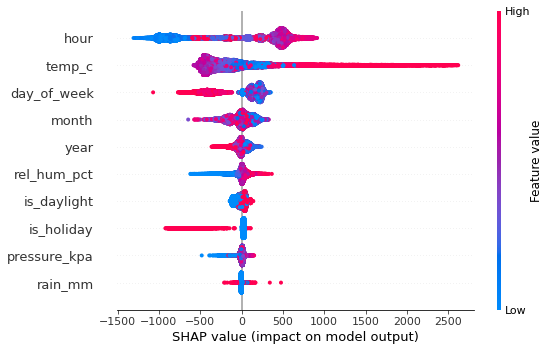

In [26]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_features))

shap.summary_plot(shap_values, X_train)

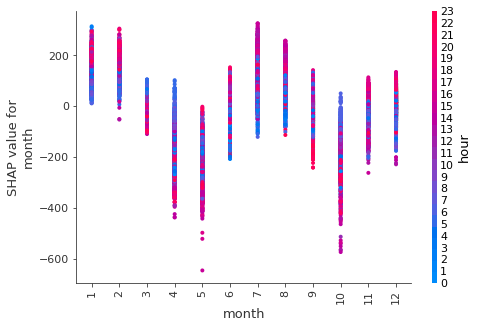

In [27]:
shap.dependence_plot('month', shap_values, X_train, interaction_index='hour')